In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from tools.analysis import *
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, rubberband_baseline_cor

# mpl.use('pgf')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex for rendering
#     'font.family': 'serif',       # Use serif font family
#     'text.usetex': True,          # Use LaTeX for text rendering
#     'pgf.rcfonts': False,         # Don't setup fonts from rc params
#     'pgf.preamble': r'\usepackage{amsmath,amsfonts,amssymb}\usepackage[T2A,T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage[ukrainian]{babel}',  # Use Ukrainian Cyrillic font
#     'font.size': 10               # Set font size
# })

In [2]:
from scipy.signal import savgol_filter, detrend
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

<Axes: >

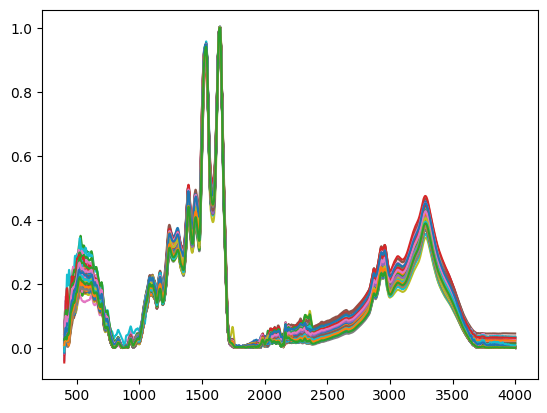

In [3]:
domain = pd.read_csv('data/domain.csv')
df = pd.read_csv('data/dataset.csv')
X = df.drop(columns=['HbA1c', 'years'])
y = df['HbA1c']
X.columns = np.ravel(domain)

X = X.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.apply(lambda row: row / max(row), axis=1)
X = X.T.apply(lambda col: savgol_filter(col, window_length=50, polyorder=2)).T
#X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)
X.T.plot(legend=False)

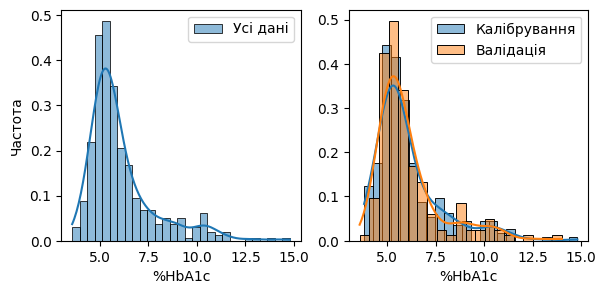

In [4]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
categories = discretizer.fit_transform(y.to_numpy().reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=categories, random_state=44)

fig, axs = plt.subplots(1, 2, figsize=(6.8, 3))
sns.histplot(y_train, kde=True, stat='density', label='Калібрування', ax=axs[1])
sns.histplot(y_test, kde=True, stat='density', label='Валідація', ax=axs[1])
sns.histplot(y, kde=True, stat='density', label='Усі дані', ax=axs[0])
axs[1].set_xlabel("%HbA1c")
axs[1].set_ylabel(None)
axs[0].set_ylabel("Частота")
axs[0].set_xlabel("%HbA1c")
axs[0].legend()
axs[1].legend()

In [5]:
def sample_features(prob1d, num_samplings):
    prob2d = np.tile(prob1d, (num_samplings, 1))
    sample = np.random.binomial(n=1, p=prob2d, size=(num_samplings, len(prob1d)))
    permutation = np.random.permutation(sample)
    return permutation

class VISSA:
    """
     Variable Iterative Space Shrinkage Approach (VISSA) algorith for variable
     selection inspired by Model Population Analysis.
     Original paper: Analyst, 2014,139, 4836-4845
    """
    def fit(self, X, y, ncomp=5, n_splits=50, num_iter=1, num_samples=2000, weights=None):
        n_samples, n_features = X.shape
        weight_history = []

        if weights is not None:
            self.weights = weights
        else:
            self.weights = np.ones(n_features) * 0.5
            
        self.num_samples = num_samples
        weight_history.append(self.weights)

        for i in range(num_iter):
            sampled_features = sample_features(self.weights, self.num_samples)
            
            progress_bar = tqdm(total=len(sampled_features), desc=f"Iteration #{i + 1}")
            progress_bar.colour = '#000000'
    
            r2s = []
            rmses = []
    
            for features in sampled_features:
                X_selected = X.iloc[:, features.astype(bool)]

                y_cv, r2, rmse = crossval_plsr(X_selected, y, cv=8, ncomp=ncomp)
                
                #ncomp, r2, rmse = find_number_components(selected_features, y, (1, 10), cv=5, message=False, returns='values')
                    
                r2s.append(r2)
                rmses.append(rmse)
                progress_bar.update(1)

                num_select = int(self.num_samples * 0.05)
                indices = np.argsort(rmses)[:num_select]

            print("R2: ", np.mean(r2s))
            print("RMSE: ", np.mean(rmses))
            
            freq = np.mean(sampled_features[indices], axis=0)
            self.weights = freq
            weight_history.append(self.weights)
            progress_bar.close()

        self.weight_history = np.array(weight_history)
            
        return self.weights

In [6]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

#vissa = VISSA()
#weights = vissa.fit(X_train, y_train, ncomp=10, num_iter=10, num_samples=1000)

In [7]:
#plt.bar(np.ravel(domain), weights)

In [8]:
#w2 = vissa.fit(X_train, y_train, ncomp=10, num_iter=10, num_samples=1000, weights=weights)

In [11]:
#pd.Series(w2).to_csv("spectra_vissa_w2.csv")

<BarContainer object of 7468 artists>

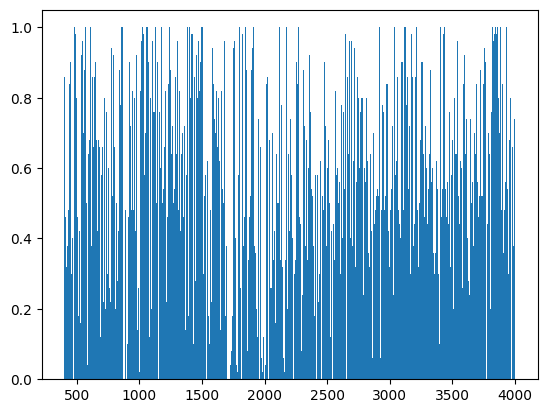

In [16]:
w2 = pd.read_csv("spectra_vissa_w2.csv").iloc[:, 1].to_numpy()
plt.bar(np.ravel(domain), w2)

In [17]:
vissa = VISSA()
w3 = vissa.fit(X_train, y_train, ncomp=10, num_iter=10, num_samples=1000, weights=w2)

Iteration #1:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6811965714227206
RMSE:  0.9956306377727329


Iteration #2:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6841725538511423
RMSE:  0.9909728552366776


Iteration #3:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6868498739345434
RMSE:  0.9867636846755569


Iteration #4:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6891909492937505
RMSE:  0.9830678808684695


Iteration #5:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6912424603543527
RMSE:  0.9798176036104482


Iteration #6:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6937487828234711
RMSE:  0.9758332426953725


Iteration #7:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.695749770832029
RMSE:  0.972638828881122


Iteration #8:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.6981897701104381
RMSE:  0.9687309385871655


Iteration #9:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.700136249650277
RMSE:  0.9656020233018369


Iteration #10:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7020342446769771
RMSE:  0.9625408588842091


893

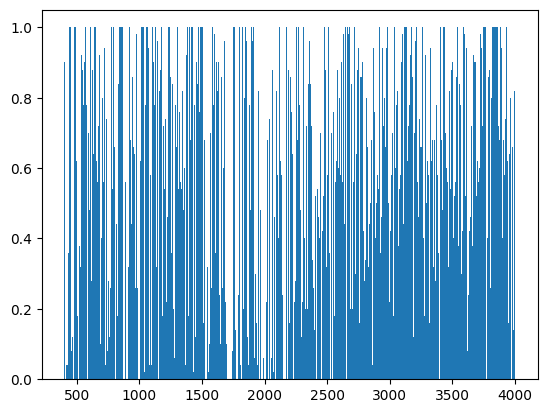

In [19]:
plt.bar(np.ravel(domain), w3)
(w3 == 1).sum()

In [20]:
w4 = vissa.fit(X_train, y_train, ncomp=10, num_iter=10, num_samples=1000, weights=w3)

Iteration #1:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7039311748694571
RMSE:  0.9594726887112361


Iteration #2:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7052201985678196
RMSE:  0.9573796242808869


Iteration #3:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7067195223491961
RMSE:  0.9549413669260778


Iteration #4:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7081504411960846
RMSE:  0.9526084854569459


Iteration #5:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7093457425972178
RMSE:  0.9506562424252651


Iteration #6:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7107618183640688
RMSE:  0.948337352818146


Iteration #7:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7119128131309213
RMSE:  0.9464483570565991


Iteration #8:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7132470648625512
RMSE:  0.9442547039853713


Iteration #9:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.7141932810319174
RMSE:  0.942694281852032


Iteration #10:   0%|          | 0/1000 [00:00<?, ?it/s]

R2:  0.715748154630056
RMSE:  0.9401283321005428


<BarContainer object of 7468 artists>

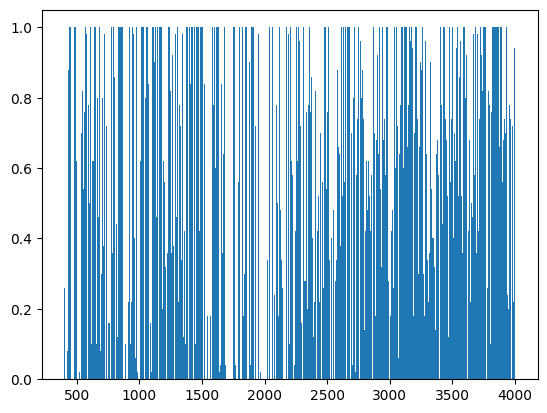

In [23]:
plt.bar(np.ravel(domain), w4)